## MOM025 Atl West Equatorial Wind dwn X3 

In [1]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage




Populating the interactive namespace from numpy and matplotlib


In [2]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print geolon_t.shape

fh=fcor/ht
print fh.shape

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print st_ocean.shape
print potrho.shape
print yt_ocean.shape


(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)


In [3]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)

#my xarray version is old, no cumsum. Should be version 0.9.2 or newer?

0.9.6


In [4]:
CntrlDir = '/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/'
AtlDwnDir = '/g/data1/v45/pas561/mom/archive/gfdl_nyf_AtlEqXn3/'
#DwnDir = '/g/data1/v45/pas561/mom/archive/wombat_jun16z_Dwn/'

ExpDirs=[CntrlDir, AtlDwnDir]
print ExpDirs

['/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/', '/g/data1/v45/pas561/mom/archive/gfdl_nyf_AtlEqXn3/']


In [5]:
#calculate the Atl BGC tracers
#load mask
#-1 is Atl and Arctic, all else is 0 
msk_file='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/basin_mask.nc'
nc = Dataset(msk_file, mode='r') # file handle, open in read only mode
msk= nc.variables['kmt'][:]
nc.close() # close the file
print msk.shape
msk[np.where(msk<-1)]=0

(1080, 1440)


## Calc the GMOC from ty_trans_rho for forcing cases

In [14]:
#dwn_gmoc=np.zeros((50,potrho.shape[0],yt_ocean.shape[0]))

Ocean_File = os.path.join(CntrlDir,'output5*/ocean.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans_rho.shape

cn_gmoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()


print cn_gmoc.shape

of=os.path.join(CntrlDir,'cntrl_gmocs.npy')
a=np.save(of,cn_gmoc)

/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/output5*/ocean.nc
(20, 80, 1080, 1440)
(20, 80, 1080)


In [6]:
Ocean_File = os.path.join(AtlDwnDir,'output*/ocean.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans_rho.shape

atldwn_gmoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print atldwn_gmoc.shape

of=os.path.join(AtlDwnDir,'atleqx3_gmocs.npy')
a=np.save(of,atldwn_gmoc)


/g/data1/v45/pas561/mom/archive/gfdl_nyf_AtlEqXn3/output*/ocean.nc
(30, 80, 1080, 1440)
(30, 80, 1080)


In [7]:
of=os.path.join(AtlDwnDir,'atleqx3_gmocs.npy')
atldwn_gmoc=np.load(of)
print atldwn_gmoc.shape

of=os.path.join(CntrlDir,'cntrl_gmocs.npy')
cntrl_gmoc=np.load(of)
print cntrl_gmoc.shape


(30, 80, 1080)
(20, 80, 1080)


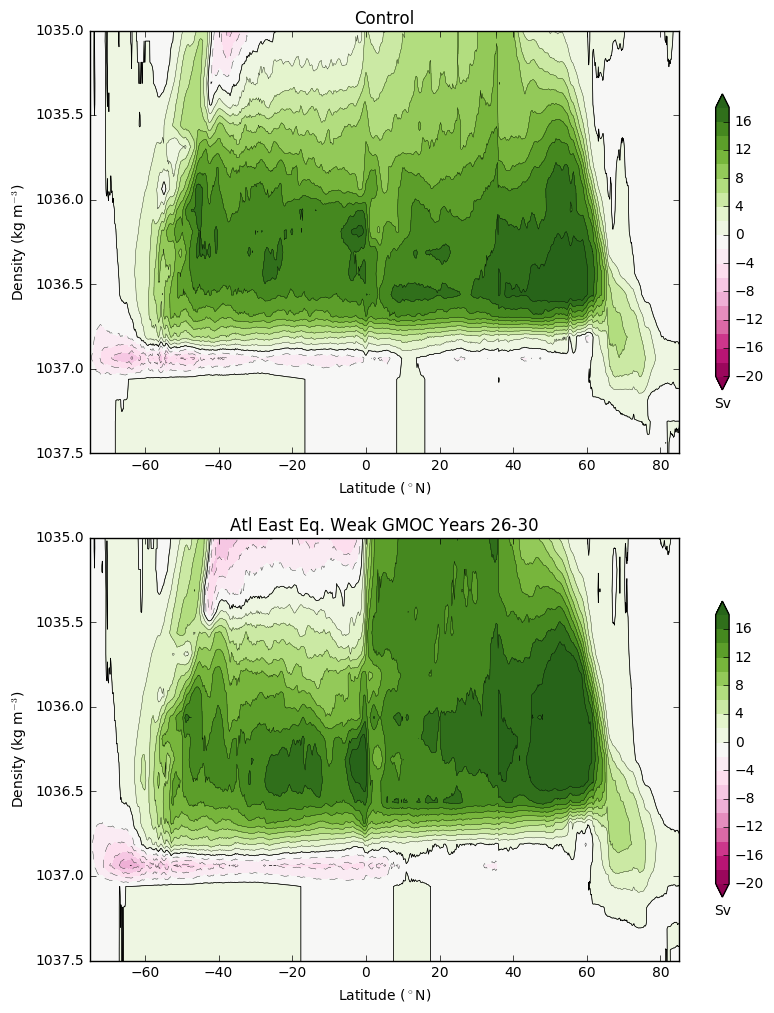

In [8]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,20,2)

t1=16
t2=20

plt.subplot(211)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
plt.title('Control')

t1=26
t2=30


plt.subplot(212)
plt.contourf(yu_ocean,potrho,np.mean(atldwn_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(atldwn_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(atldwn_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
tit='Atl East Eq. Weak GMOC Years '+str(t1)+'-'+str(t2)
plt.title(tit)



In [9]:
print potrho
print potrho[70]
j1 = 230
j2=235
print yt_ocean[j1:j2]

j1 = 130
j2=135
print yt_ocean[j1:j2]

j1 = 370
j2=375
print yt_ocean[j1:j2]
print potrho[65]

j1 = 600
j2=610
print yt_ocean[j1:j2]

j1 = 765
j2=770
print yt_ocean[j1:j2]
print potrho[68]



[ 1028.0625  1028.1875  1028.3125  1028.4375  1028.5625  1028.6875
  1028.8125  1028.9375  1029.0625  1029.1875  1029.3125  1029.4375
  1029.5625  1029.6875  1029.8125  1029.9375  1030.0625  1030.1875
  1030.3125  1030.4375  1030.5625  1030.6875  1030.8125  1030.9375
  1031.0625  1031.1875  1031.3125  1031.4375  1031.5625  1031.6875
  1031.8125  1031.9375  1032.0625  1032.1875  1032.3125  1032.4375
  1032.5625  1032.6875  1032.8125  1032.9375  1033.0625  1033.1875
  1033.3125  1033.4375  1033.5625  1033.6875  1033.8125  1033.9375
  1034.0625  1034.1875  1034.3125  1034.4375  1034.5625  1034.6875
  1034.8125  1034.9375  1035.0625  1035.1875  1035.3125  1035.4375
  1035.5625  1035.6875  1035.8125  1035.9375  1036.0625  1036.1875
  1036.3125  1036.4375  1036.5625  1036.6875  1036.8125  1036.9375
  1037.0625  1037.1875  1037.3125  1037.4375  1037.5625  1037.6875
  1037.8125  1037.9375]
1036.8125
[-55.42352179 -55.28138944 -55.13874852 -54.9955939  -54.8519288 ]
[-67.34918424 -67.24358565 -

(50,)
[-55.42352179 -55.28138944 -55.13874852 -54.9955939  -54.8519288 ]
1036.8125
(20, 80, 5)
(20,)
(31,)
[-67.34918424 -67.24358565 -67.13798706 -67.03238847 -66.92678988]
1036.8125
(20, 80, 5)
(20,)
(31,)
[-30.34766755 -30.13168517 -29.91523058 -29.69830307 -29.48090748]
1036.1875
(20, 80, 5)
(20,)
(31,)
[ 55.42352179  55.56514233  55.70625623  55.84686025  55.9869596 ]
1036.1875
(20, 80, 5)
(20,)
(31,)
[ 24.81117791  25.03789472  25.26419195  25.49006945  25.71552189
  25.94054921  26.1651461   26.38931259  26.61304344  26.83633873]
1036.1875
(20, 80, 5)
(20,)
(31,)


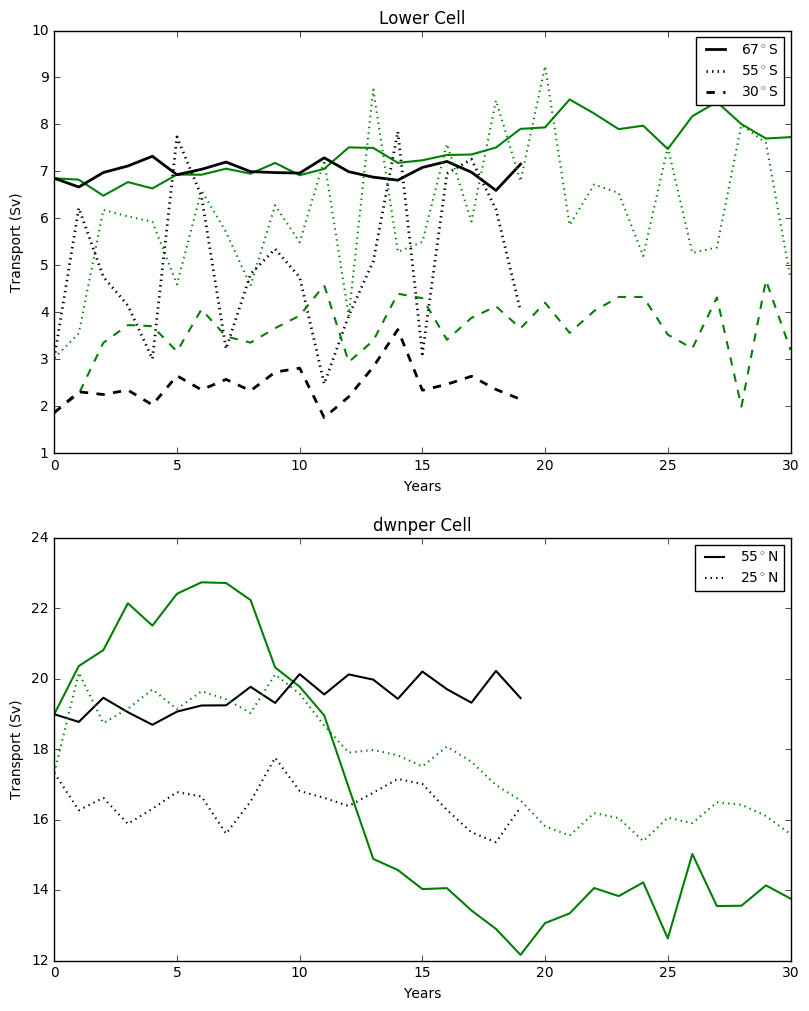

In [10]:
#plot time series of AABW
T=np.arange(50)
print T.shape

# average between j1 and j2
# do lower cell at 55S
j1 = 230
j2=235

print yt_ocean[j1:j2]
print potrho[70]

cntrl55_psj = cntrl_gmoc[:,:,j1:j2]
print cntrl55_psj.shape
cntrl55_psj_bar = np.mean(cntrl55_psj,2)
cntrl55_psj_ts = -np.min(cntrl55_psj_bar[:,70:],1)
print cntrl55_psj_ts.shape

dwn55_psj = atldwn_gmoc[:,:,j1:j2]
dwn55_psj_bar = np.mean(dwn55_psj,2)
dwn55_psj_ts = -np.min(dwn55_psj_bar[:,70:],1)
dwn55_psj_ts = np.insert(dwn55_psj_ts,0,cntrl55_psj_ts[0])
print dwn55_psj_ts.shape

# do lower cell at 67S
j1 = 130
j2=135

print yt_ocean[j1:j2]
print potrho[70]

cntrl67_psj = cntrl_gmoc[:,:,j1:j2]
print cntrl67_psj.shape
cntrl67_psj_bar = np.mean(cntrl67_psj,2)
cntrl67_psj_ts = -np.min(cntrl67_psj_bar[:,70:],1)
print cntrl67_psj_ts.shape

dwn67_psj = atldwn_gmoc[:,:,j1:j2]
dwn67_psj_bar = np.mean(dwn67_psj,2)
dwn67_psj_ts = -np.min(dwn67_psj_bar[:,70:],1)
dwn67_psj_ts = np.insert(dwn67_psj_ts,0,cntrl67_psj_ts[0])
print dwn67_psj_ts.shape

# do lower cell at 30S
j1 = 370
j2=375

print yt_ocean[j1:j2]
print potrho[65]

cntrl30_psj = cntrl_gmoc[:,:,j1:j2]
print cntrl30_psj.shape
cntrl30_psj_bar = np.mean(cntrl30_psj,2)
cntrl30_psj_ts = -np.min(cntrl30_psj_bar[:,65:],1)
print cntrl30_psj_ts.shape

dwn30_psj = atldwn_gmoc[:,:,j1:j2]
dwn30_psj_bar = np.mean(dwn30_psj,2)
dwn30_psj_ts = -np.min(dwn30_psj_bar[:,65:],1)
dwn30_psj_ts = np.insert(dwn30_psj_ts,0,cntrl30_psj_ts[0])
print dwn30_psj_ts.shape


plt.subplot(211)
plt.plot(dwn67_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(cntrl67_psj_ts,linestyle='-',color='k',label='67$^\circ$S',linewidth=2)
plt.plot(dwn55_psj_ts,linestyle=':',color='g',linewidth=1.5)
plt.plot(cntrl55_psj_ts,linestyle=':',color='k',label='55$^\circ$S',linewidth=2)
plt.plot(dwn30_psj_ts,linestyle='--',color='g',linewidth=1.5)
plt.plot(cntrl30_psj_ts,linestyle='--',color='k',label='30$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('Lower Cell')
plt.legend(fontsize=10)

#do nh dwnper cell at 55N
j1 = 765
j2=770

print yt_ocean[j1:j2]
print potrho[65]

cntrl55N_psj = cntrl_gmoc[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl55N_psj_bar = np.mean(cntrl55N_psj,2)
rho_cntrl55N_psj_ts = np.max(cntrl55N_psj_bar[:,68:],1)
print rho_cntrl55N_psj_ts.shape

dwn55N_psj = atldwn_gmoc[:,:,j1:j2]
dwn55N_psj_bar = np.mean(dwn55N_psj,2)
dwn55N_psj_ts = np.max(dwn55N_psj_bar[:,68:],1)
rho_dwn55N_psj_ts = np.insert(dwn55N_psj_ts,0,rho_cntrl55N_psj_ts[0])
print rho_dwn55N_psj_ts.shape


#do nh dwnper cell at 25N
j1 = 600
j2=610

print yt_ocean[j1:j2]
print potrho[65]

cntrl25N_psj = cntrl_gmoc[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl25N_psj_bar = np.mean(cntrl25N_psj,2)
rho_cntrl25N_psj_ts = np.max(cntrl25N_psj_bar[:,68:],1)
print rho_cntrl25N_psj_ts.shape

dwn25N_psj = atldwn_gmoc[:,:,j1:j2]
dwn25N_psj_bar = np.mean(dwn25N_psj,2)
dwn25N_psj_ts = np.max(dwn25N_psj_bar[:,68:],1)
rho_dwn25N_psj_ts = np.insert(dwn25N_psj_ts,0,rho_cntrl25N_psj_ts[0])
print rho_dwn25N_psj_ts.shape

plt.subplot(212)
plt.plot(rho_dwn55N_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(rho_cntrl55N_psj_ts,linestyle='-',color='k',label='55$^\circ$N',linewidth=1.5)
plt.plot(rho_dwn25N_psj_ts,linestyle=':',color='g',linewidth=1.5)
plt.plot(rho_cntrl25N_psj_ts,linestyle=':',color='k',label='25$^\circ$N',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('dwnper Cell')
plt.legend(fontsize=10)


In [11]:
#calculate the Atl MOCs
#load mask
#-1 is Atl and Arctic, all else is 0 
msk_file='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/basin_mask.nc'
nc = Dataset(msk_file, mode='r') # file handle, open in read only mode
msk= nc.variables['kmt'][:]
nc.close() # close the file
print msk.shape
msk[np.where(msk<-1)]=0

#calculate the AMOC for CNTRL in rho space
Ocean_File = os.path.join(CntrlDir,'output5*/ocean.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans_rho.shape

ty=ff.ty_trans_rho*msk*-1
print ty.shape

#check masking
#plt.imshow(ty[9,60,:,:])
#plt.gca().invert_yaxis()
#plt.show()

#cn_amoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()
amoc=ty[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print amoc.shape

of=os.path.join(CntrlDir,'cntrl_amoc_rho.npy')
a=np.save(of,amoc)

#do in zspace
Ocean_File = os.path.join(CntrlDir,'output5*/ocean.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans.shape

ty=ff.ty_trans*msk*-1
print ty.shape
amoc=ty[:,:,:,:].sum('xt_ocean').cumsum('st_ocean').load()
print amoc.shape

of=os.path.join(CntrlDir,'cntrl_amoc_z.npy')
a=np.save(of,amoc)

#calculate the AMOC for dwn in rho space
Ocean_File = os.path.join(AtlDwnDir,'output*/ocean.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans_rho.shape

ty=ff.ty_trans_rho*msk*-1
print ty.shape
amoc=ty[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()
print amoc.shape

of=os.path.join(AtlDwnDir,'atldwn_amoc_rho.npy')
a=np.save(of,amoc)

#do in zspace
Ocean_File = os.path.join(AtlDwnDir,'output*/ocean.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans.shape
ty=ff.ty_trans*msk*-1
print ty.shape
amoc=ty[:,:,:,:].sum('xt_ocean').cumsum('st_ocean').load()
print amoc.shape

of=os.path.join(AtlDwnDir,'atldwn_amoc_z.npy')
a=np.save(of,amoc)





(1080, 1440)
/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/output5*/ocean.nc
(20, 80, 1080, 1440)
(20, 80, 1080, 1440)
(20, 80, 1080)
/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/output5*/ocean.nc
(20, 50, 1080, 1440)
(20, 50, 1080, 1440)
(20, 50, 1080)
/g/data1/v45/pas561/mom/archive/gfdl_nyf_AtlEqXn3/output*/ocean.nc
(30, 80, 1080, 1440)
(30, 80, 1080, 1440)
(30, 80, 1080)
/g/data1/v45/pas561/mom/archive/gfdl_nyf_AtlEqXn3/output*/ocean.nc
(30, 50, 1080, 1440)
(30, 50, 1080, 1440)
(30, 50, 1080)


In [14]:
of=os.path.join(AtlDwnDir,'atldwn_amoc_z.npy')
dwn_amoc_z=np.load(of)
print dwn_amoc_z.shape

of=os.path.join(CntrlDir,'cntrl_amoc_z.npy')
cntrl_amoc_z=np.load(of)
print cntrl_amoc_z.shape

of=os.path.join(AtlDwnDir,'atldwn_amoc_rho.npy')
dwn_amoc_rho=np.load(of)
print dwn_amoc_rho.shape

of=os.path.join(CntrlDir,'cntrl_amoc_rho.npy')
cntrl_amoc_rho=np.load(of)
print cntrl_amoc_rho.shape

(30, 50, 1080)
(20, 50, 1080)
(30, 80, 1080)
(20, 80, 1080)


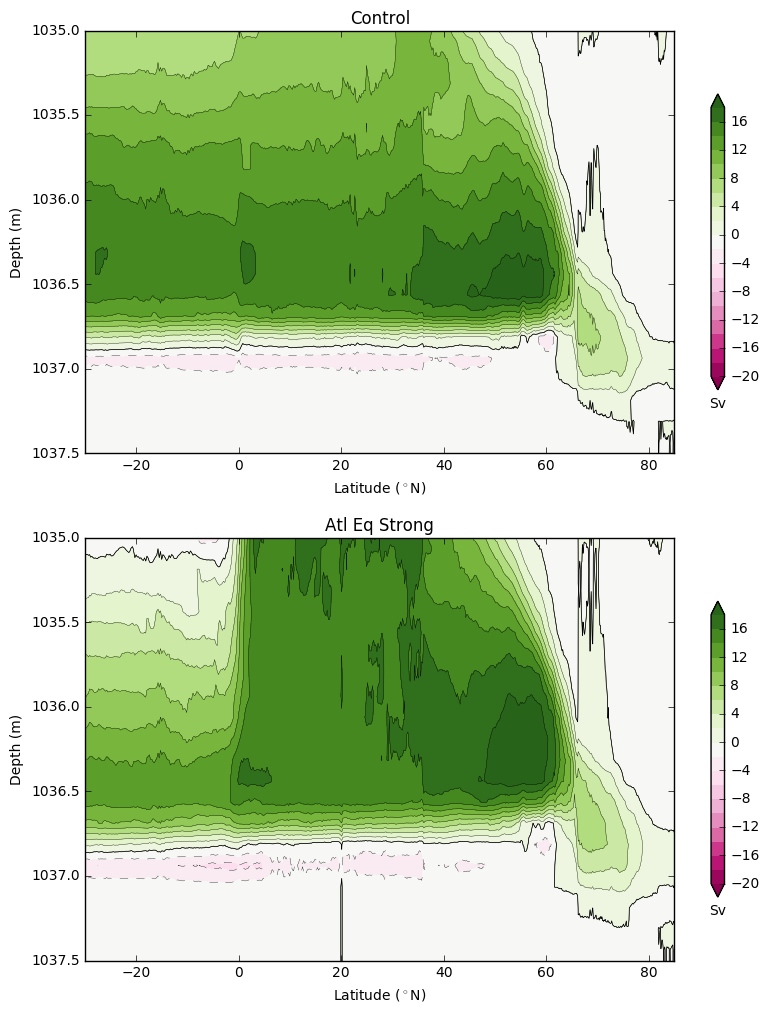

In [15]:
#Amoc in density space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,20,2)

t1=16
t2=20

plt.subplot(211)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('Control')

t1=26
t2=30

plt.subplot(212)
plt.contourf(yu_ocean,potrho,np.mean(dwn_amoc_rho[t1:t2:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(dwn_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(dwn_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('Atl Eq Strong')



(20,)
[ 55.42352179  55.56514233  55.70625623  55.84686025  55.9869596 ]
1036.1875
(20, 80, 5)
(20, 80)
(20,)
(31,)
[ 35.58791037  35.79095887  35.99348842  36.19550076  36.39699177]
1036.1875
(20, 80, 5)
(20,)
(31,)
[ 24.81117791  25.03789472  25.26419195  25.49006945  25.71552189
  25.94054921  26.1651461   26.38931259  26.61304344  26.83633873]
1036.1875
(20, 80, 5)
(20,)
(31,)


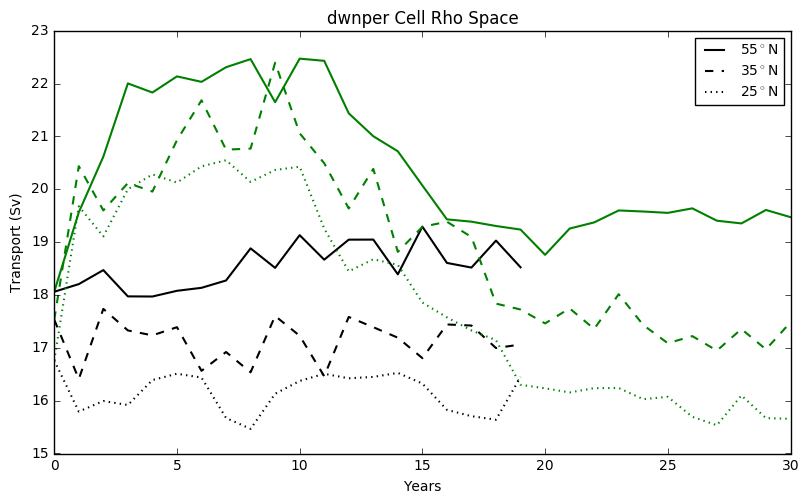

In [16]:
#plot time series of AMOC in rho space
T=np.arange(20)
print T.shape

#do nh dwnper cell at 55N
j1 = 765
j2=770

print yt_ocean[j1:j2]
print potrho[65]
st_min=65

cntrl55N_psj = cntrl_amoc_rho[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl55N_psj_bar = np.mean(cntrl55N_psj,2)
print cntrl55N_psj_bar.shape
rho_cntrl55N_psj_ts = np.max(cntrl55N_psj_bar[:,st_min:],1)
print rho_cntrl55N_psj_ts.shape

dwn55N_psj = dwn_amoc_rho[:,:,j1:j2]
dwn55N_psj_bar = np.mean(dwn55N_psj,2)
dwn55N_psj_ts = np.max(dwn55N_psj_bar[:,st_min:],1)
rho_dwn55N_psj_ts = np.insert(dwn55N_psj_ts,0,rho_cntrl55N_psj_ts[0])
print rho_dwn55N_psj_ts.shape

#do nh dwnper cell at 35N
j1 = 650
j2=655

print yt_ocean[j1:j2]
print potrho[st_min]

cntrl35N_psj = cntrl_amoc_rho[:,:,j1:j2]
print cntrl35N_psj.shape
cntrl35N_psj_bar = np.mean(cntrl35N_psj,2)
rho_cntrl35N_psj_ts = np.max(cntrl35N_psj_bar[:,st_min:],1)
print rho_cntrl35N_psj_ts.shape

dwn35N_psj = dwn_amoc_rho[:,:,j1:j2]
dwn35N_psj_bar = np.mean(dwn35N_psj,2)
dwn35N_psj_ts = np.max(dwn35N_psj_bar[:,st_min:],1)
rho_dwn35N_psj_ts = np.insert(dwn35N_psj_ts,0,rho_cntrl35N_psj_ts[0])
print rho_dwn35N_psj_ts.shape


#do nh dwnper cell at 25N
j1 = 600
j2=610

print yt_ocean[j1:j2]
print potrho[st_min]

cntrl25N_psj = cntrl_amoc_rho[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl25N_psj_bar = np.mean(cntrl25N_psj,2)
rho_cntrl25N_psj_ts = np.max(cntrl25N_psj_bar[:,st_min:],1)
print rho_cntrl25N_psj_ts.shape

dwn25N_psj = dwn_amoc_rho[:,:,j1:j2]
dwn25N_psj_bar = np.mean(dwn25N_psj,2)
dwn25N_psj_ts = np.max(dwn25N_psj_bar[:,st_min:],1)
rho_dwn25N_psj_ts = np.insert(dwn25N_psj_ts,0,rho_cntrl25N_psj_ts[0])
print rho_dwn25N_psj_ts.shape

plt.subplot(211)
plt.plot(rho_dwn55N_psj_ts[0:49],linestyle='-',color='g',linewidth=1.5)
plt.plot(rho_cntrl55N_psj_ts,linestyle='-',color='k',label='55$^\circ$N',linewidth=1.5)
plt.plot(rho_dwn35N_psj_ts[0:49],linestyle='--',color='g',linewidth=1.5)
plt.plot(rho_cntrl35N_psj_ts,linestyle='--',color='k',label='35$^\circ$N',linewidth=1.5)
plt.plot(rho_dwn25N_psj_ts[0:49],linestyle=':',color='g',linewidth=1.5)
plt.plot(rho_cntrl25N_psj_ts,linestyle=':',color='k',label='25$^\circ$N',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('dwnper Cell Rho Space')
plt.legend(fontsize=10)


(20,)
1030.6875
(20, 80, 1080)
(20, 1080)
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.
   5.   6.   7.   8.   9.  10.]
1036.1875
(20, 1080)
[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5  5. ]


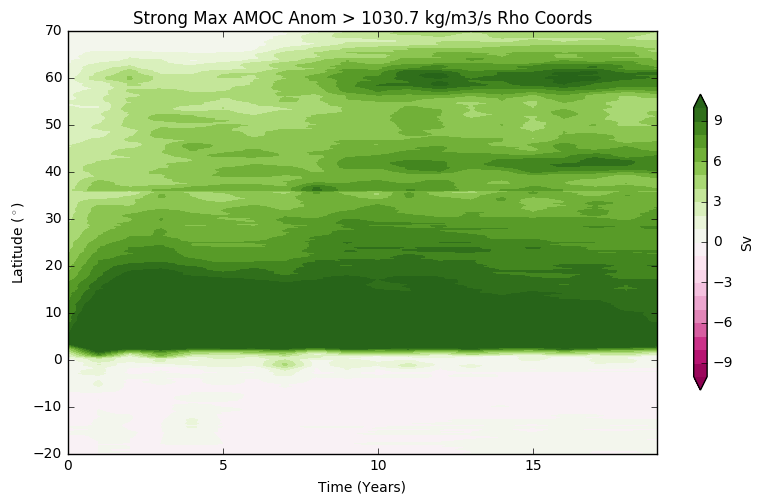

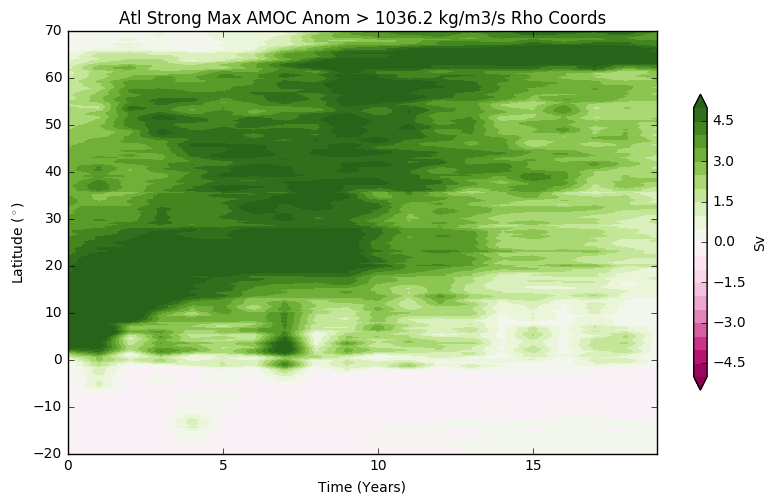

In [20]:
#AMOC Hovmoeller in rho space
time = np.arange(0,20,1)
print time.shape


print potrho[21]
st_min=21

#a=np.mean(cntrl_amoc_rho[0:4,:,:],axis=0)
#print 'a', a.shape

dwn_amoc_rho_anom= dwn_amoc_rho[0:20,:,:] - cntrl_amoc_rho[0:20,:,:]
print dwn_amoc_rho_anom.shape

dwn_amoc_rho_anom_max = np.max(dwn_amoc_rho_anom[:,st_min:,:],1)
print dwn_amoc_rho_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(-10,10,21)
print clev

plt.subplot(211)
plt.contourf(time,yu_ocean,dwn_amoc_rho_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Years)')
plt.ylim([-20,70])
plt.title('Strong Max AMOC Anom > 1030.7 kg/m3/s Rho Coords')

print potrho[65]
st_min=65

#a=np.mean(cntrl_amoc_rho[0:4,:,:],axis=0)
#print 'a', a.shape

dwn_amoc_rho_anom_max = np.max(dwn_amoc_rho_anom[:,st_min:,:],1)
print dwn_amoc_rho_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(-5,5,21)
print clev

plt.subplot(212)
plt.contourf(time,yu_ocean,dwn_amoc_rho_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Years)')
plt.ylim([-20,70])
plt.title('Atl Strong Max AMOC Anom > 1036.2 kg/m3/s Rho Coords')

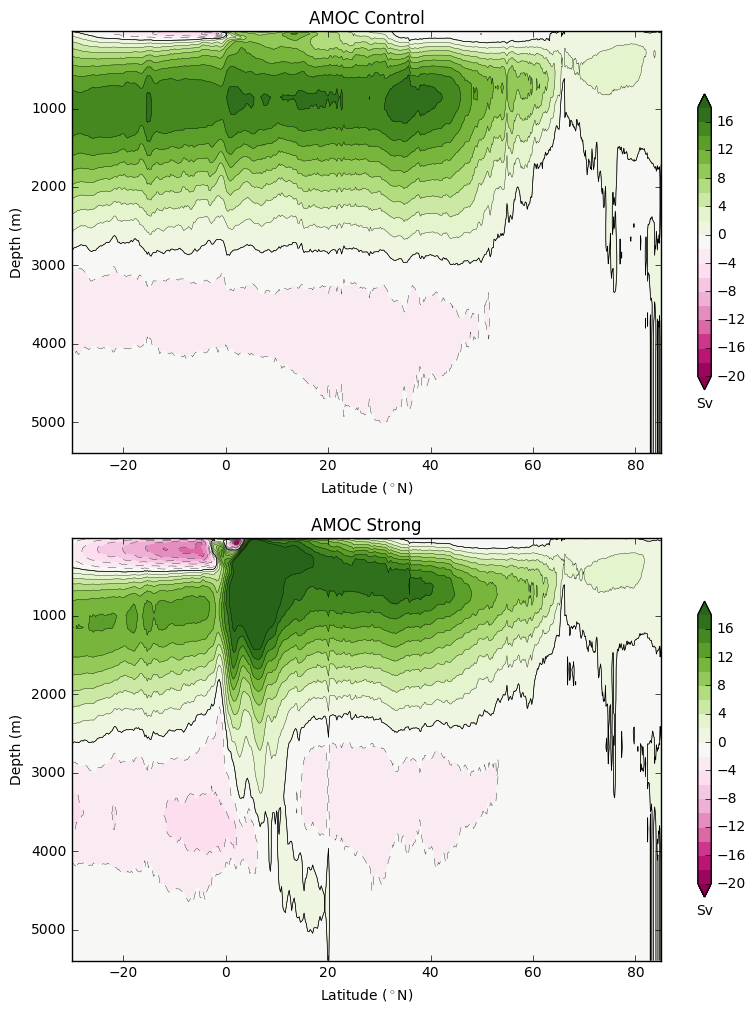

In [21]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,20,2)
t1=16
t2=20

plt.subplot(211)
plt.contourf(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('AMOC Control')

t1=26
t2=30

plt.subplot(212)
plt.contourf(yu_ocean,st_ocean,np.mean(dwn_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(dwn_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(dwn_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('AMOC Strong')



(20,)
[ 55.42352179  55.56514233  55.70625623  55.84686025  55.9869596 ]
382.36505127
(20, 50, 5)
(20, 50)
(20,)
(31,)
[ 35.58791037  35.79095887  35.99348842  36.19550076  36.39699177]
382.36505127
(20, 50, 5)
(20,)
(31,)
[ 24.81117791  25.03789472  25.26419195  25.49006945  25.71552189
  25.94054921  26.1651461   26.38931259  26.61304344  26.83633873]
382.36505127
(20, 50, 5)
(20,)
(31,)


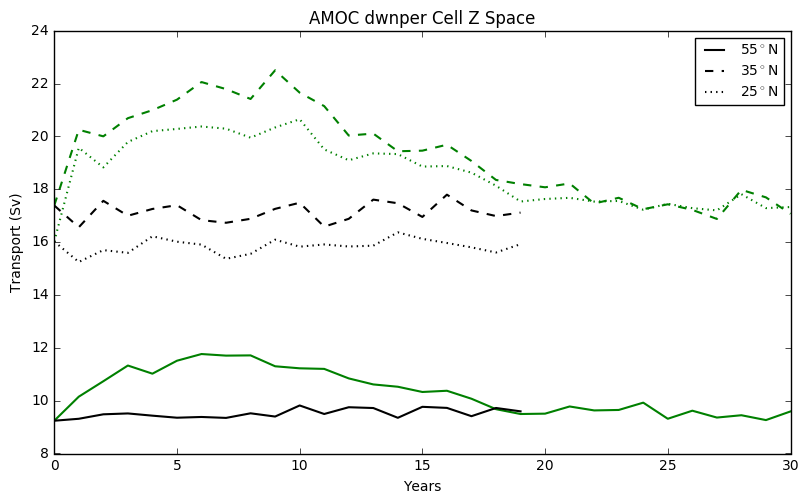

In [23]:
#plot time series of AMOC in z space
T=np.arange(20)
print T.shape

#do nh dwnper cell at 55N
j1 = 765
j2=770

print yt_ocean[j1:j2]
print st_ocean[21]
st_min=21

cntrl55N_psj = cntrl_amoc_z[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl55N_psj_bar = np.mean(cntrl55N_psj,2)
print cntrl55N_psj_bar.shape
cntrl55N_psj_ts = np.max(cntrl55N_psj_bar[:,st_min:],1)
print cntrl55N_psj_ts.shape

dwn55N_psj = dwn_amoc_z[:,:,j1:j2]
dwn55N_psj_bar = np.mean(dwn55N_psj,2)
dwn55N_psj_ts = np.max(dwn55N_psj_bar[:,st_min:],1)
dwn55N_psj_ts = np.insert(dwn55N_psj_ts,0,cntrl55N_psj_ts[0])
print dwn55N_psj_ts.shape

#do nh dwnper cell at 35N
j1 = 650
j2=655

print yt_ocean[j1:j2]
print st_ocean[st_min]

cntrl35N_psj = cntrl_amoc_z[:,:,j1:j2]
print cntrl35N_psj.shape
cntrl35N_psj_bar = np.mean(cntrl35N_psj,2)
cntrl35N_psj_ts = np.max(cntrl35N_psj_bar[:,st_min:],1)
print cntrl35N_psj_ts.shape

dwn35N_psj = dwn_amoc_z[:,:,j1:j2]
dwn35N_psj_bar = np.mean(dwn35N_psj,2)
dwn35N_psj_ts = np.max(dwn35N_psj_bar[:,st_min:],1)
dwn35N_psj_ts = np.insert(dwn35N_psj_ts,0,cntrl35N_psj_ts[0])
print dwn35N_psj_ts.shape


#do nh dwnper cell at 25N
j1 = 600
j2=610

print yt_ocean[j1:j2]
print st_ocean[st_min]

cntrl25N_psj = cntrl_amoc_z[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl25N_psj_bar = np.mean(cntrl25N_psj,2)
cntrl25N_psj_ts = np.max(cntrl25N_psj_bar[:,st_min:],1)
print cntrl25N_psj_ts.shape

dwn25N_psj = dwn_amoc_z[:,:,j1:j2]
dwn25N_psj_bar = np.mean(dwn25N_psj,2)
dwn25N_psj_ts = np.max(dwn25N_psj_bar[:,st_min:],1)
dwn25N_psj_ts = np.insert(dwn25N_psj_ts,0,cntrl25N_psj_ts[0])
print dwn25N_psj_ts.shape

plt.subplot(211)
plt.plot(dwn55N_psj_ts[0:49],linestyle='-',color='g',linewidth=1.5)
plt.plot(cntrl55N_psj_ts,linestyle='-',color='k',label='55$^\circ$N',linewidth=1.5)
plt.plot(dwn35N_psj_ts[0:49],linestyle='--',color='g',linewidth=1.5)
plt.plot(cntrl35N_psj_ts,linestyle='--',color='k',label='35$^\circ$N',linewidth=1.5)
plt.plot(dwn25N_psj_ts[0:49],linestyle=':',color='g',linewidth=1.5)
plt.plot(cntrl25N_psj_ts,linestyle=':',color='k',label='25$^\circ$N',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('AMOC dwnper Cell Z Space')
plt.legend(fontsize=10)


(20,)
110.096153259
(20, 50, 1080)
(20, 1080)
[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5  5. ]
728.692077637
(20, 1080)
[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5  5. ]


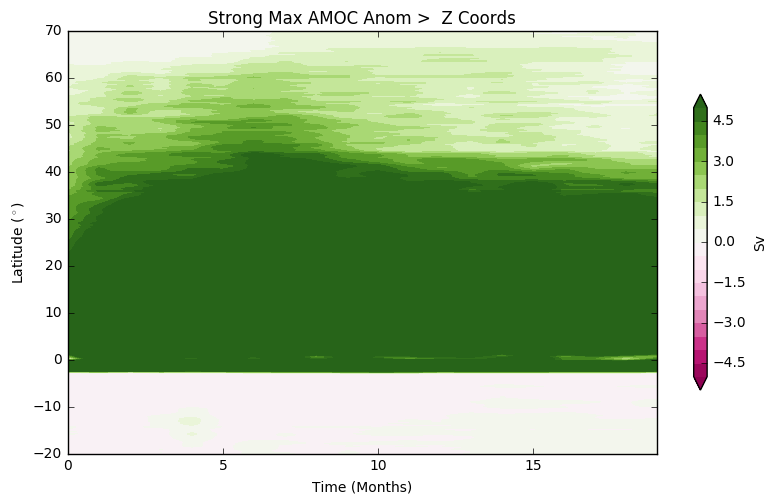

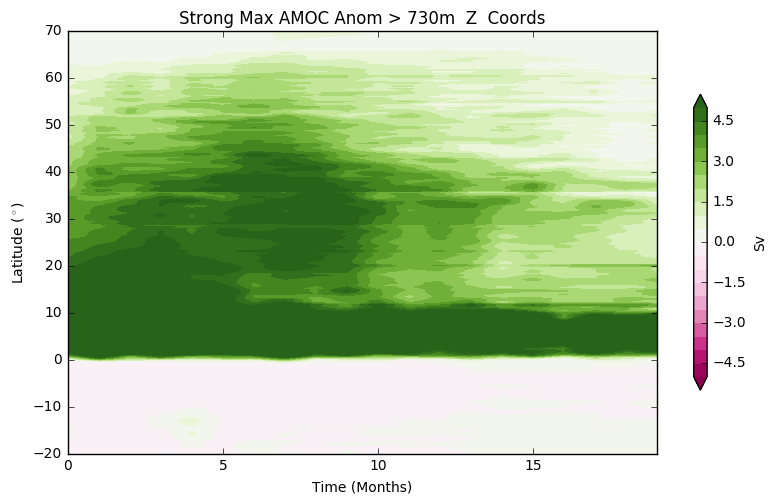

In [24]:
#Hovmoeller in z space
time = np.arange(0,20,1)
print time.shape


print st_ocean[10]
st_min=10


dwn_amoc_z_anom= dwn_amoc_z[0:20,:,:] - cntrl_amoc_z[0:20,:,:]
print dwn_amoc_z_anom.shape

dwn_amoc_z_anom_max = np.max(dwn_amoc_z_anom[:,st_min:,:],1)
print dwn_amoc_z_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(-5,5,21)
print clev

plt.subplot(211)
plt.contourf(time,yu_ocean,dwn_amoc_z_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
plt.ylim([-20,70])
plt.title('Strong Max AMOC Anom >  Z Coords')

print st_ocean[25]
st_min=25


dwn_amoc_z_anom_max = np.max(dwn_amoc_z_anom[:,st_min:,:],1)
print dwn_amoc_z_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(-5,5,21)
print clev

plt.subplot(212)
plt.contourf(time,yu_ocean,dwn_amoc_z_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
plt.ylim([-20,70])
plt.title('Strong Max AMOC Anom > 730m  Z  Coords')

In [25]:
#north atl mld, sea ice changes, surface and bottom velocity anomalies in Atl., density and carbon.

Ocean_File = os.path.join(CntrlDir,'output5*/ocean.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
nyf_mld=ff.mld[0:10,:,:].mean('time').load()
print nyf_mld.shape

Ocean_File = os.path.join(AtlDwnDir,'output*/ocean.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
dwn_mld=ff.mld.load()
print dwn_mld.shape

/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(1080, 1440)
(30, 1080, 1440)


mld bounds lon1 lon2 lat1 lat2 [-99.875] [ 50.125] [ 30.13168517] 89.947282327


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:72: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


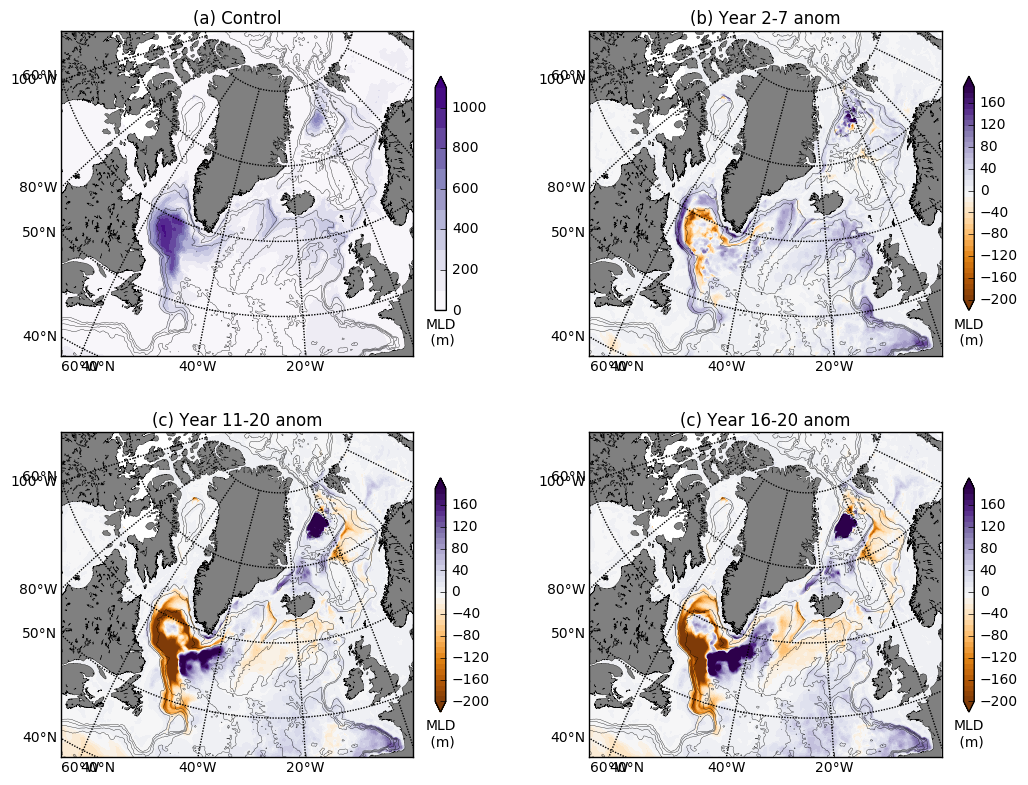

In [27]:
#plot mld
ii1=np.argwhere(xt_ocean>-100)# and lat<-45)
ii2=np.argwhere(xt_ocean>50)# and lat<-45)
jj1=np.argwhere(yt_ocean>30)# and lat<-45)
jj2=np.argwhere(yt_ocean>80)# and lat<-45)
ii1=ii1[0]
ii2=ii2[0]
jj1=jj1[0]
jj2=1079
#jj2=jj2[0]

print "mld bounds lon1 lon2 lat1 lat2", xt_ocean[ii1], xt_ocean[ii2], yt_ocean[jj1], yt_ocean[jj2]

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

plt.subplot(221)#,axisbg='gray')
clev = np.arange(0,1200,100)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,nyf_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.Purples, levels=clev, extend='max') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(a) Control')
#plt.show()

clev = np.arange(-200,200,10)
#clev2 = np.arange(-200,200,10)

plt.subplot(222)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,np.mean(dwn_mld[2:7,jj1:jj2,ii1:ii2],axis=0)-nyf_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(b) Year 2-7 anom')
#plt.show()


plt.subplot(223)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,np.mean(dwn_mld[10:20,jj1:jj2,ii1:ii2],axis=0)-nyf_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(c) Year 11-20 anom')
#plt.show()

plt.subplot(224)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,np.mean(dwn_mld[16:20,jj1:jj2,ii1:ii2],axis=0)-nyf_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(c) Year 16-20 anom')
#plt.show()

plt.show()




In [24]:
print np.max(fh[540:1080,:])
print np.min(fh[540:1080,:])

3.59161e-06
4.91751e-09


In [25]:
Ocean_File = os.path.join(CntrlDir,'output*/ice__*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
nyf_cn=ff.CN[0:120,:,:,:].mean('time').sum('ct').load()
print nyf_cn.shape

Ocean_File = os.path.join(DwnDir,'output*/ice__*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
dwn_cn1=ff.CN[0:120,:,:,:].mean('time').sum('ct').load()
print dwn_cn1.shape
dwn_cn2=ff.CN[120:240,:,:,:].mean('time').sum('ct').load()
print dwn_cn2.shape
dwn_cn3=ff.CN[240:360,:,:,:].mean('time').sum('ct').load()
print dwn_cn3.shape



(600, 5, 1080, 1440)
(1080, 1440)
(1080, 1440)
(1080, 1440)
(1080, 1440)
